In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Reshape
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt 
import cv2
import random

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28
print(num_sample, " - ", input_dim)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
55000  -  784


## Variational AutoEncoder

In [3]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build network
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [4]:
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtain a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model

In [5]:
model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)

[Epoch 0] Loss: 166.1533660888672, Recon loss: 156.03675842285156, Latent loss: 10.116595268249512
[Epoch 5] Loss: 135.3345947265625, Recon loss: 124.42003631591797, Latent loss: 10.914546966552734
[Epoch 10] Loss: 133.91885375976562, Recon loss: 123.09587097167969, Latent loss: 10.822986602783203
[Epoch 15] Loss: 127.52800750732422, Recon loss: 116.27909851074219, Latent loss: 11.248909950256348
[Epoch 20] Loss: 124.96163177490234, Recon loss: 113.5850601196289, Latent loss: 11.37656021118164
[Epoch 25] Loss: 124.75137329101562, Recon loss: 113.31466674804688, Latent loss: 11.4367094039917
[Epoch 30] Loss: 116.08502960205078, Recon loss: 104.4234848022461, Latent loss: 11.661543846130371
[Epoch 35] Loss: 117.24324035644531, Recon loss: 105.50564575195312, Latent loss: 11.737592697143555
[Epoch 40] Loss: 115.77679443359375, Recon loss: 104.23382568359375, Latent loss: 11.542974472045898
[Epoch 45] Loss: 118.30817413330078, Recon loss: 106.47273254394531, Latent loss: 11.835427284240723

## Recognition of Numbers

In [6]:
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.argmax(data.test.labels, axis=1)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
#Variables
img_size = 28
img_size_flat = img_size*img_size
img_shape_full = (img_size, img_size, 1)
num_classes = 10
num_channels = 1

In [8]:
#Model to recongnize numbers
model_n = Sequential()
model_n.add(InputLayer(input_shape=(img_size_flat,)))
model_n.add(Reshape(img_shape_full))
model_n.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same', activation='relu'))
model_n.add(MaxPooling2D(pool_size=2, strides=2))
model_n.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same', activation='relu'))
model_n.add(MaxPooling2D(pool_size=2, strides=2))
model_n.add(Flatten())
model_n.add(Dense(128, activation='relu'))
model_n.add(Dense(num_classes, activation='softmax'))

In [9]:
optimizer = Adam(lr = 1e-3)
model_n.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_n.fit(x=data.train.images, y=data.train.labels,epochs=2, batch_size=128)

Epoch 1/2
55000/55000 [==============================] - 42s 764us/step - loss: 0.2206 - acc: 0.9347
Epoch 2/2
55000/55000 [==============================] - 41s 754us/step - loss: 0.0575 - acc: 0.9820


## Generate Captcha

In [11]:
numbers_captcha = [5, 5, 5]

In [53]:
def generate_number(number):
    img_number = np.empty((28,28))
    while(True):
        z = np.random.normal(size=[1, 5])
        x_generated = model.generator(z)
        number_pred = np.argmax(model_n.predict(x_generated[0, :].reshape(1,784)), axis=1) 
        if(number_pred[0] == number):
            img_number = x_generated[0, :].reshape(28,28)    
            return img_number
        
def add_line(img, items):
    cv2.line(img,(random.randint(0,28*items),random.randint(0,28)), (random.randint(0,28*items),random.randint(0,28)), (1, 0, 0), 1)
    return img

In [51]:
def generate_captcha_v2(numbers, t, r, size):
    
    items = len(numbers)
    img_cv = np.empty((size, size*items))
    
    m = size
                
    for i in range(size):
        for j in range(size*items):
            img_cv[i,j] = 0
            
    for i in range(items):
        
        img_generate = np.empty((size,size))        
        img_generate = generate_number(numbers[i])
        img_gray = image_to_gray(img_generate)
        
        #Rotation
        rotation = random.randint(-r,r)
        M = cv2.getRotationMatrix2D(((size-1)/2.0, (size-1)/2.0), rotation, 1)
        img_rotate = cv2.warpAffine(img_gray, M, (size, size))
        
        #Translation
        translation = random.randint(-t,t)
        for j in range(size):
            #if((28*i+j+translation)>-1 and (28*i+j+translation)< size*items):
            #    if(np.sum(img_gray[0:28, j:j+1]) != 0):
            #        img_cv[0:28, 28*i+j+translation:28*(i+1)+j+1+translation] = img_rotate[0:28, j:j+1]
            img_cv[0:28, 28*i+j:28*(i+1)+j+1] = img_rotate[0:28, j:j+1]
        
    return add_noise(invert_gray(img_cv, size, size, items))
    #return img_cv
    
def image_to_gray(img):
    rows, cols = img.shape
    for i in range(rows):
        for j in range(cols):
            if(img[i,j] > 0.4):
                img[i,j] = 1
            else:
                img[i,j] = 0
    return img

def invert_gray(img_cv, rows, cols, items):
    #Convert to 0 and 1
    for i in range(rows):
        for j in range(cols*items):
            if(img_cv[i,j] == 0):
                img_cv[i,j] = 1
            else:
                img_cv[i,j] = 0
    return img_cv
    
def add_noise(img, noise_factor=0.3):
    img = img + np.random.randn(*img.shape) * noise_factor
    img = img.clip(0., 1.)
    return img

#size of 1 frame, items, and number_lines
def image_with_line(size, items, number_lines):
    img = np.empty((size, size*items))
    for i in range(size):
        for j in range(size*items):
            img[i,j] = 0
            
    for k in range(number_lines):
        img = add_line(img, items)
    
    return img

In [86]:
def suma_images(img1, img2, items):
    img = np.empty((28, 28*items)) 
    for i in range(28):
        for j in range(28*items):
            if img1[i,j] != 1:
                img[i,j] = img1[i,j]+img2[i,j]
    return img1+img2

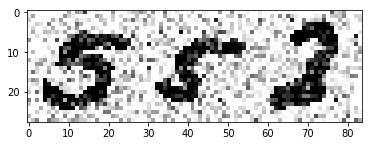

In [70]:
items = 3
numbers_captcha = [5, 5, 2]
captcha = generate_captcha_v2(numbers_captcha, 10, 20, 28)
plt.imshow(captcha,cmap='gray')

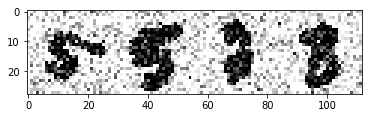

In [79]:
items = 3
numbers_captcha = [5, 5, 2, 3]
captcha = generate_captcha_v2(numbers_captcha, 10, 20, 28)
plt.imshow(captcha,cmap='gray')

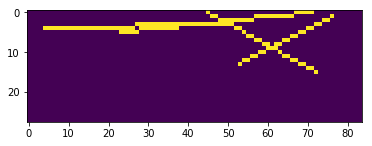

In [57]:
lines = image_with_line(28,3, 4)
plt.imshow(lines)

In [85]:
captcha

array([[1.        , 0.7402159 , 0.93884386, ..., 1.        , 1.        ,
        0.95833674],
       [0.93246605, 0.86869481, 1.        , ..., 0.9291094 , 0.55191325,
        1.        ],
       [1.        , 0.88157829, 1.        , ..., 1.        , 0.86569114,
        1.        ],
       ...,
       [1.        , 0.64592137, 0.77792295, ..., 0.43862493, 1.        ,
        1.        ],
       [1.        , 1.        , 0.84049112, ..., 0.81653434, 0.45469352,
        1.        ],
       [0.19282564, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

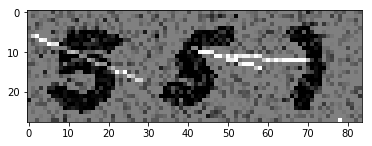

In [87]:
items = 3
numbers_captcha = [5, 5, 2]
captcha = generate_captcha_v2(numbers_captcha, 10, 20, 28)
lines = image_with_line(28,items, 4)
plt.imshow(suma_images(captcha,lines, items),cmap='gray')